In [61]:
import pandas as pd

df_train = pd.read_csv('orders0206_train.csv', sep='|', parse_dates=['time'])
df_test = pd.read_csv('orders0206_train.csv', sep='|', parse_dates=['time'])

df_info = pd.read_csv('infos.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()
df_train["time"] = pd.to_datetime(df_train["time"], format='%Y-%m-%d %H:%M:%S')

In [62]:
df_train.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [79]:
#create column only containing date
df_train['date'] = df_train['time'].dt.date
df_train.head()

,time,transactID,itemID,order,salesPrice,date
0,2018-01-01 00:01:56,2278968,450,1,17.42,2018-01-01
4842,2018-01-02 00:02:35,2269586,8330,1,14.75,2018-01-02
8998,2018-01-03 00:04:08,2273845,576,1,116.16,2018-01-03
11441,2018-01-04 00:04:34,15317,273,1,15.41,2018-01-04
19534,2018-01-05 00:09:20,2274134,4296,1,1.21,2018-01-05


In [81]:
#add up all orders that were made on one day
df_train['sum_sold'] = df_train['order'].groupby(df_train['date']).transform('sum')
df_train.head()

In [101]:
#limit data to relevant variables only -> sum_sold and date
seasonal = df_train[["sum_sold", "date"]]
#remove duplicates
df_duplicates_removed = seasonal.drop_duplicates(subset=['sum_sold', 'date'])
df_duplicates_removed.head()
#date to datetime format ?error message?
df_duplicates_removed['date'] = pd.to_datetime(df_duplicates_removed['date'])

C:\Users\a.kati\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


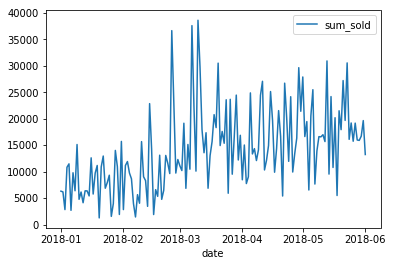

In [88]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

#use line plot to visually inspect data for seasonality 
df_duplicates_removed.plot.line(x = 'date', 
             y = 'sum_sold')
plt.show()

#we definetly see a general upward trend

we definetly see a general upward trend

**What kind of seasonalities are relevant for us?**
-Time of Day -> not really relevant if we forecast for a two week period
-Day of the week -> not really relevant if we forecast for a two week period
-Weekly -> relevant
-Monthly -> relevant
-Yearly -> not enough data

**How do we know that an effect is seasonal if we only have data for half a year(periodicity is unknown)?**
**Do we want to correct for seasonality?(No)**


In [90]:
#average number of sold items per day -> 14090,026
df_duplicates_removed.loc[:,"sum_sold"].mean()

#average number of sold items per week

#average number of sold items per month

14090.026315789473

In [111]:
#checking for seasonality in terms of festivities (only those in all parts of Germany):
df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-01-01']
#new years sold: 6305

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-03-30']
#easter friday 12196 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-04-02']
#easter monday 15026 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-01']
#labor day 27885 items sold

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-10']
#'christi Himmelfahrt' 16567

df_duplicates_removed.loc[df_duplicates_removed['date'] == '2018-05-21']
#pfingsten 27206



,sum_sold,date
1540637,27206,2018-05-21


In [115]:
#exponential smoothing seems to be a thing we could do, note that this doesnt refer to seasonality but to trend
#gives error message
#model = ExponentialSmoothing(df_duplicates_removed, trend="add", seasonal="add", seasonal_periods=6)